In [39]:
import os                          
import json                         
import argparse                    
import math                         
from pathlib import Path           
from collections import defaultdict 
import logging    

In [40]:
!pip3 install tqdm
!pip3 install rapidfuzz
!pip3 install scikit-learn
!pip3 install networkx
!pip3 install joblib

In [91]:
!pip3 install pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 94.7 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.8/683.8 kB 47.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [fastparquet] [fastparquet]


In [92]:
!pip3 freeze > requirements-updated.txt

In [116]:
import numpy as np                                  # numerics
import pandas as pd                                 # tabular data
from tqdm import tqdm                               # progress bars
from rapidfuzz.fuzz import token_sort_ratio         # string similarity for buckets
from sklearn.feature_extraction.text import TfidfVectorizer  # TF–IDF for text
from sklearn.preprocessing import OneHotEncoder, RobustScaler # encoders & scaling
from sklearn.decomposition import TruncatedSVD                  # PCA-like for sparse
from sklearn.mixture import GaussianMixture                     # GMM (MLE)
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, adjusted_rand_score
from scipy import sparse                             
import networkx as nx                                 
import joblib            

In [117]:
RANDOM_SEED = 42                                      # global seed for reproducibility
ARTIFACTS_DIR = Path("artifacts")                     # root output folder
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)      # ensure root exists

# Feature config
TFIDF_NGRAM_RANGE = (1, 2)                            # unigrams + bigrams
TFIDF_MAX_FEATURES = 50000                            # cap vocabulary size
TFIDF_MIN_DF = 3                                      # ignore rare tokens
PCA_COMPONENTS = 96                                   # reduced dimension (TruncatedSVD for sparse)
TOP_N_AISLES = 200                                    # one-hot the top N aisles

# Bucketing (P1) config
BUCKET_NAME_SIM_THRESHOLD = 0.92                      # token_sort_ratio threshold
BUCKET_PRICE_TOL_PCT = 0.10                           # ±10% price_per_100g tolerance

# GMM config
K_GRID = [32, 48, 64, 80, 96]                         # cluster counts to try
COV_TYPES = ["diag", "full"]                          # covariance types to try
GMM_N_INIT = 5                                        # restarts
GMM_MAX_ITER = 500                                    # EM steps
GMM_TOL = 1e-3                                        # convergence tol
GMM_REG_COVAR = 1e-6                                  # small covariance regularizer
TINY_COMPONENT_WEIGHT = 0.001                         # reject models with >10% comps below this

# Graph (k-partite) config
P3_LEVEL = "aisle_id"                                 # fallback level: 'aisle_id' or 'department_id'
P2P_SIM_PRUNE = 0.20                                  # cosine similarity threshold for P2→P2
P2P_MAX_EDGES_PER_NODE = 15                           # max neighbors per cluster
P2P_FALLBACK_WEIGHT = 0.20    

In [118]:
logging.basicConfig(
    level=logging.INFO,                                # set to DEBUG for more detail
    format="%(asctime)s | %(levelname)s | %(message)s"
)

In [120]:
def ensure_dir(path: Path):
    """Ensure a directory exists."""
    path.mkdir(parents=True, exist_ok=True)
    

In [121]:
def load_tables(data_dir: Path):
    """Load CSVs matching the ER diagram (lowercase names)."""
    # Build paths to expected CSVs
    products_path = data_dir / "products_with_prices_ingredients_nutrition.csv"  # enriched products
    orders_path = data_dir / "orders.csv"                                        # orders metadata
    prior_path = data_dir / "order_products_prior.csv"                           # order-product links (optional now)
    aisles_path = data_dir / "aisles.csv"                                        # aisles lookup
    depts_path = data_dir / "departments.csv"                                    # depts lookup

    # Read CSVs to DataFrames
    products = pd.read_csv(products_path)            # contains ingredients, nutrition, price
    orders = pd.read_csv(orders_path)                # used later if you add alternation
    order_products_prior = pd.read_csv(prior_path) if prior_path.exists() else None  # optional now
    aisles = pd.read_csv(aisles_path)                # aisle_id -> aisle
    departments = pd.read_csv(depts_path)            # department_id -> department

    # Return as a dict for convenience
    return {
        "products": products,
        "orders": orders,
        "order_products_prior": order_products_prior,
        "aisles": aisles,
        "departments": departments
    }

In [122]:
def normalize_products(df: pd.DataFrame) -> pd.DataFrame:
    """Minimal cleaning + derive price_per_100g if unit can be inferred from name."""
    # Copy to avoid mutating original
    df = df.copy()

    # renaming columns
    column_mapping = {
    'Price (USD)': 'price_usd',
    'Ingredients': 'ingredients',
    'Calories': 'calories',
    'Carbs (g)': 'carbs_g',
    'Protein (g)': 'protein_g',
    'Fat (g)': 'fat_g',
    'Sugar Added (g)': 'sugar_added_g',
    'Sugar Natural (g)': 'sugar_natural_g'
}
    df = df.rename(columns=column_mapping)

    # Ensure expected columns exist (raise helpful error if not)
    expected_cols = {
        "product_id","product_name","aisle_id","department_id","price_usd",
        "ingredients","calories","carbs_g","protein_g","fat_g","sugar_added_g","sugar_natural_g"
    }
    missing = expected_cols - set(c.lower() for c in df.columns)
    if missing:
        raise ValueError(f"Missing expected columns (lowercase): {missing}")

    # Normalize column names to lowercase for consistency
    df.columns = [c.lower() for c in df.columns]

    # Create very light size parsing: try to pick a number from product_name, assume grams if 'g' is present
    # (You can replace this with your robust parser later.)
    size_vals = []
    for name in df["product_name"].fillna(""):
        # naive parse: find last number in name
        tokens = [t for t in name.replace("oz"," ").replace("ml"," ").replace("g"," ").split() if t.replace(".","",1).isdigit()]
        size_val = float(tokens[-1]) if tokens else np.nan
        size_vals.append(size_val)
    df["size_value_guess"] = size_vals  # keep guess separate

    # Derive a crude price per 100g/ml if size is available (fallback to NaN, we’ll impute later)
    df["price_per_100g"] = np.where(
        df["size_value_guess"].notna() & (df["size_value_guess"] > 0),
        df["price_usd"] / df["size_value_guess"] * 100.0,
        np.nan
    )

    # Clip absurd numeric values to reasonable ranges for stability
    df["calories"] = df["calories"].clip(0, 900)                # kcal per 100g plausible cap
    df["carbs_g"] = df["carbs_g"].clip(0, 100)
    df["protein_g"] = df["protein_g"].clip(0, 100)
    df["fat_g"] = df["fat_g"].clip(0, 100)
    df["sugar_added_g"] = df["sugar_added_g"].clip(0, 100)
    df["sugar_natural_g"] = df["sugar_natural_g"].clip(0, 100)
    df["price_per_100g"] = df["price_per_100g"].clip(lower=0.01, upper=100.0)

    # Median-impute missing price_per_100g by aisle (then global)
    df["price_per_100g"] = df.groupby("aisle_id")["price_per_100g"].transform(
        lambda s: s.fillna(s.median())
    )
    df["price_per_100g"] = df["price_per_100g"].fillna(df["price_per_100g"].median())

    return df

# -----------------------------
# Feature engineering (TF–IDF + numeric + one-hot)
# -----------------------------
def build_product_features(products: pd.DataFrame, aisles: pd.DataFrame):
    """Create sparse feature matrix X_product and metadata frame."""
    # Work on a copy
    df = products.copy()

    # Keep a meta frame with IDs and a few numeric columns for later joins
    meta_cols = [
        "product_id", "product_name", "aisle_id", "department_id",
        "price_usd", "price_per_100g", "calories", "carbs_g", "protein_g",
        "fat_g", "sugar_added_g", "sugar_natural_g", "ingredients"
    ]
    meta = df[meta_cols].copy()

    # Build TF–IDF on product_name + ingredients concatenated
    text_series = (df["product_name"].fillna("") + " " + df["ingredients"].fillna("")).astype(str)
    tfidf = TfidfVectorizer(
        ngram_range=TFIDF_NGRAM_RANGE,
        max_features=TFIDF_MAX_FEATURES,
        min_df=TFIDF_MIN_DF,
        stop_words="english",
        sublinear_tf=True
    )
    X_text = tfidf.fit_transform(text_series)

    # Build dense numeric block (robust scaled): price_per_100g + macros
    numeric = df[["price_per_100g","calories","carbs_g","protein_g","fat_g","sugar_added_g","sugar_natural_g"]].astype(float)
    scaler = RobustScaler()
    X_num = scaler.fit_transform(numeric)   # returns dense np.ndarray
    # One-hot top aisles (others → "other")
    top_aisle_ids = df["aisle_id"].value_counts().nlargest(TOP_N_AISLES).index.tolist()
    aisle_mapped = df["aisle_id"].where(df["aisle_id"].isin(top_aisle_ids), other=-1)  # -1 = other
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    X_aisle = ohe.fit_transform(aisle_mapped.values.reshape(-1,1))

    # Concatenate sparse (text + aisle) with dense numeric (convert numeric to sparse first)
    X_num_sparse = sparse.csr_matrix(X_num)
    X_product = sparse.hstack([X_text, X_num_sparse, X_aisle], format="csr")

    # Build and fit SVD (PCA-like) for dimensionality reduction (works on sparse)
    svd = TruncatedSVD(n_components=PCA_COMPONENTS, random_state=RANDOM_SEED)
    X_product_pca = svd.fit_transform(X_product)

    # Persist vectorizers/scalers for later reuse
    feat_dir = ARTIFACTS_DIR / "features"
    ensure_dir(feat_dir)
    joblib.dump(tfidf, feat_dir / "tfidf.joblib")
    joblib.dump(scaler, feat_dir / "robust_scaler.joblib")
    joblib.dump(ohe, feat_dir / "aisle_ohe.joblib")
    joblib.dump(svd, feat_dir / "svd.joblib")

    # Save the reduced product features
    np.save(feat_dir / "X_product_pca.npy", X_product_pca)
    meta.to_parquet(feat_dir / "meta_product.parquet", index=False, engine="fastparquet")

    # Return the reduced features and meta
    return X_product_pca, meta

In [123]:
def make_buckets(meta: pd.DataFrame) -> pd.DataFrame:
    """Cluster near-duplicates into BucketID via blocking + name similarity + price/unit proximity."""
    # Create a 'brand' and 'type' heuristic from product_name for blocking
    # Very naive: brand = first token; type = next 1-2 tokens (you can replace with your robust parser)
    def parse_brand(name: str) -> str:
        toks = name.split()
        return toks[0].lower() if toks else ""
    def parse_type(name: str) -> str:
        toks = name.split()
        return " ".join(t.lower() for t in toks[1:3]) if len(toks) > 1 else ""

    # Compute brand/type fields
    meta = meta.copy()
    meta["brand"] = meta["product_name"].fillna("").map(parse_brand)
    meta["type"] = meta["product_name"].fillna("").map(parse_type)

    # Prepare an output mapping (product_id → BucketID)
    bucket_ids = {}              # assigned bucket per product
    next_bucket = 1              # sequential bucket id

    # Group by block keys to limit pairwise comparisons
    for (brand, _type, aisle_id), block in tqdm(
        meta.groupby(["brand","type","aisle_id"], dropna=False),
        desc="Bucketing blocks"
    ):
        # Convert block to list of indices for pairwise checks
        idxs = list(block.index)
        # Union-Find structure stored as parent pointers
        parent = {i: i for i in idxs}

        # Helper: find with path compression
        def find(i):
            while parent[i] != i:
                parent[i] = parent[parent[i]]
                i = parent[i]
            return i

        # Helper: union sets
        def union(i, j):
            ri, rj = find(i), find(j)
            if ri != rj:
                parent[rj] = ri

        # Build pairwise unions where name similarity and price proximity agree
        for a in range(len(idxs)):
            for b in range(a+1, len(idxs)):
                i, j = idxs[a], idxs[b]
                # Compute token-sort similarity on names
                name_i = block.loc[i, "product_name"] or ""
                name_j = block.loc[j, "product_name"] or ""
                sim = token_sort_ratio(name_i, name_j) / 100.0
                # Price/unit proximity check
                pi = block.loc[i, "price_per_100g"]
                pj = block.loc[j, "price_per_100g"]
                price_ok = (abs(pi - pj) / max(pi, pj, 1e-6)) <= BUCKET_PRICE_TOL_PCT
                # If both pass, union
                if sim >= BUCKET_NAME_SIM_THRESHOLD and price_ok:
                    union(i, j)

        # Assign a bucket id per root
        root_to_bucket = {}
        for i in idxs:
            r = find(i)
            if r not in root_to_bucket:
                root_to_bucket[r] = next_bucket
                next_bucket += 1
            bucket_ids[block.loc[i, "product_id"]] = root_to_bucket[r]

    # Build the mapping DataFrame
    bmap = pd.DataFrame({
        "product_id": list(bucket_ids.keys()),
        "bucket_id": list(bucket_ids.values())
    })

    # Save artifacts
    bdir = ARTIFACTS_DIR / "buckets"
    ensure_dir(bdir)
    bmap.to_parquet(bdir / "product_to_bucket.parquet", index=False, engine="fastparquet")

    # Compute bucket-level stats (size, mean price/nutrition)
    stats = meta.merge(bmap, on="product_id", how="left") \
                .groupby("bucket_id").agg(
                    size=("product_id","count"),
                    mean_price_per_100g=("price_per_100g","mean"),
                    mean_calories=("calories","mean")
                ).reset_index()
    stats.to_parquet(bdir / "bucket_stats.parquet", index=False, engine="fastparquet")

    return bmap


In [124]:
def average_by_bucket(X_prod_pca: np.ndarray, meta: pd.DataFrame, bmap: pd.DataFrame):
    """Average reduced product features within each bucket → bucket vectors."""
    # Join meta to bucket ids to align rows
    meta_b = meta.merge(bmap, on="product_id", how="left")
    # Create arrays for fast aggregation
    buckets = meta_b["bucket_id"].values
    # Map bucket_id to consecutive indices for compact arrays
    uniq_buckets, inv = np.unique(buckets, return_inverse=True)
    # Initialize sum and counts per bucket
    sums = np.zeros((len(uniq_buckets), X_prod_pca.shape[1]), dtype=np.float32)
    counts = np.zeros(len(uniq_buckets), dtype=np.int64)
    # Accumulate
    for i, bi in enumerate(inv):
        sums[bi] += X_prod_pca[i]
        counts[bi] += 1
    # Mean per bucket
    X_bucket = (sums.T / np.clip(counts, 1, None)).T
    # Build a DataFrame mapping row -> bucket_id
    bucket_index = pd.DataFrame({"bucket_id": uniq_buckets})
    # Save
    fdir = ARTIFACTS_DIR / "features"
    ensure_dir(fdir)
    np.save(fdir / "X_bucket_pca.npy", X_bucket)
    bucket_index.to_parquet(fdir / "bucket_index.parquet", index=False, engine="fastparquet")
    return X_bucket, bucket_index

In [125]:
def fit_select_gmm(X_bucket: np.ndarray):
    """Fit GMM over k and covariance types; select by BIC with sanity checks."""
    # Track best model and metrics
    best = {"bic": math.inf, "model": None, "k": None, "cov": None, "tiny_frac": None, "sil": None}

    # Try all combinations
    for cov in COV_TYPES:
        for k in K_GRID:
            # Initialize model
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=cov,
                n_init=GMM_N_INIT,
                max_iter=GMM_MAX_ITER,
                tol=GMM_TOL,
                reg_covar=GMM_REG_COVAR,
                random_state=RANDOM_SEED
            )
            # Fit on bucket-level features
            gmm.fit(X_bucket)
            # Compute BIC
            bic = gmm.bic(X_bucket)
            # Check tiny components fraction
            tiny_frac = (gmm.weights_ < TINY_COMPONENT_WEIGHT).mean()
            # Compute a rough silhouette on responsibilities' argmax (only if k>1)
            labels = gmm.predict(X_bucket)
            sil = silhouette_score(X_bucket, labels) if k > 1 else 0.0

            # Log attempt
            logging.info(f"GMM try k={k} cov={cov} BIC={bic:.1f} tinyFrac={tiny_frac:.3f} sil={sil:.3f}")

            # Selection: lowest BIC, reject if too many tiny components
            if tiny_frac <= 0.10 and bic < best["bic"]:
                best.update({"bic": bic, "model": gmm, "k": k, "cov": cov, "tiny_frac": tiny_frac, "sil": sil})

    # Error if no model passed the tiny fraction sanity
    if best["model"] is None:
        raise RuntimeError("No GMM configuration passed tiny component sanity check. Adjust K_GRID or TINY_COMPONENT_WEIGHT.")

    # Save model
    gdir = ARTIFACTS_DIR / "gmm"
    ensure_dir(gdir)
    joblib.dump(best["model"], gdir / "model.joblib")

    # Compute final labels and responsibilities
    labels = best["model"].predict(X_bucket)
    resp = best["model"].predict_proba(X_bucket)

    # Save labels/responsibilities
    np.save(gdir / "responsibilities.npy", resp)
    pd.DataFrame({"cluster_id": labels}).to_parquet(gdir / "bucket_labels.parquet", index=False, engine="fastparquet")

    # Save metrics summary
    summary = {
        "k": best["k"], "covariance_type": best["cov"], "bic": best["bic"],
        "tiny_component_fraction": float(best["tiny_frac"]), "silhouette": float(best["sil"])
    }
    with open(gdir / "gmm_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Return the trained model and labels
    return best["model"], labels, resp

In [126]:
def build_kpartite_graph(bucket_index: pd.DataFrame, bucket_labels: np.ndarray,
                         X_bucket: np.ndarray, meta: pd.DataFrame,
                         bmap: pd.DataFrame, p3_level: str = P3_LEVEL):
    """Create nodes & edges for P1 (buckets), P2 (clusters), P3 (aisle/department) and similarity-based P2→P2 edges."""
    # Merge bucket_index (row order for X_bucket) with labels
    bi = bucket_index.copy()
    bi["cluster_id"] = bucket_labels

    # Build P1 nodes (buckets) with simple stats
    meta_b = meta.merge(bmap, on="product_id", how="left")
    bucket_stats = meta_b.groupby("bucket_id").agg(
        members=("product_id","count"),
        mean_price_per_100g=("price_per_100g","mean"),
        mean_calories=("calories","mean"),
        aisle_id=("aisle_id","first"),
        department_id=("department_id","first")
    ).reset_index()

    # Build P2 nodes (clusters) with centroid vectors
    df_p2 = bi.groupby("cluster_id").agg(
        n_buckets=("bucket_id","count")
    ).reset_index()

    # Compute cluster centroids by averaging bucket vectors (X_bucket rows align with bucket_index)
    centroids = []
    for cid in df_p2["cluster_id"].tolist():
        rows = bi.index[bi["cluster_id"] == cid].tolist()
        centroids.append(X_bucket[rows].mean(axis=0))
    C = np.vstack(centroids)  # shape: (n_clusters, d)

    # Build P3 nodes (aisle or department). We’ll use unique values present in bucket_stats.
    if p3_level not in {"aisle_id","department_id"}:
        raise ValueError("p3_level must be 'aisle_id' or 'department_id'")
    p3_nodes = bucket_stats[p3_level].dropna().unique().tolist()

    # Edges P1→P2: bucket to its owning cluster (weight=1.0)
    edges_p1_p2 = bi[["bucket_id","cluster_id"]].copy()
    edges_p1_p2["weight"] = 1.0

    # Edges P2→P3: cluster to its P3 node (use majority of buckets’ P3 assignment; we just pick first mode)
    cluster_to_p3 = {}
    for cid, sub in bucket_stats.merge(bi, on="bucket_id")[["cluster_id", p3_level]].groupby("cluster_id"):
        # choose the most frequent p3 for this cluster
        p3_value = sub[p3_level].mode(dropna=True)
        cluster_to_p3[cid] = int(p3_value.iloc[0]) if not p3_value.empty else int(sub[p3_level].dropna().iloc[0])
    edges_p2_p3 = pd.DataFrame({
        "cluster_id": list(cluster_to_p3.keys()),
        p3_level: list(cluster_to_p3.values()),
        "weight": P2P_FALLBACK_WEIGHT
    })

    # Edges P2→P2: similarity among cluster centroids within same P3
    # First build mapping cluster_id → centroid row index
    cluster_ids = df_p2["cluster_id"].tolist()
    cid_to_row = {cid: i for i, cid in enumerate(cluster_ids)}

    # Invert mapping: p3_value → list of cluster_ids
    p3_to_clusters = defaultdict(list)
    for cid, p3_val in cluster_to_p3.items():
        p3_to_clusters[p3_val].append(cid)

    # Compute cosine similarity within each p3 group, prune < threshold, top-k per node
    def cos_sim(a, b):
        # safe cosine sim between row vectors
        denom = (np.linalg.norm(a) * np.linalg.norm(b))
        return float(a @ b / denom) if denom > 0 else 0.0

    p2p_rows = []
    for p3_val, cids in p3_to_clusters.items():
        # For each pair in this p3 bucket, compute similarity
        for i in range(len(cids)):
            u = cids[i]
            u_vec = C[cid_to_row[u]]
            sims = []
            for j in range(len(cids)):
                if i == j: 
                    continue
                v = cids[j]
                v_vec = C[cid_to_row[v]]
                s = cos_sim(u_vec, v_vec)
                if s >= P2P_SIM_PRUNE:
                    sims.append((u, v, s))
            # Keep top-k by similarity
            sims.sort(key=lambda t: t[2], reverse=True)
            sims = sims[:P2P_MAX_EDGES_PER_NODE]
            p2p_rows.extend(sims)

    # Symmetrize by averaging u→v and v→u if both present
    # Build dict to accumulate pairs with both directions
    pair_weights = defaultdict(list)
    for u, v, w in p2p_rows:
        key = tuple(sorted((u, v)))
        pair_weights[key].append(w)
    # Average and explode back to directed edges (both directions)
    edges_u, edges_v, edges_w = [], [], []
    for (u, v), ws in pair_weights.items():
        w = float(np.mean(ws))
        edges_u.extend([u, v])
        edges_v.extend([v, u])
        edges_w.extend([w, w])
    edges_p2_p2 = pd.DataFrame({"cluster_u": edges_u, "cluster_v": edges_v, "weight": edges_w})
    edges_p2_p2["source"] = "centroid"

    # Persist nodes/edges to disk
    gdir = ARTIFACTS_DIR / "graph"
    ensure_dir(gdir)
    # Nodes
    bucket_stats.to_csv(gdir / "nodes_p1_buckets.csv", index=False)
    df_p2.assign(centroid_row=df_p2["cluster_id"].map(cid_to_row)).to_csv(gdir / "nodes_p2_clusters.csv", index=False)
    pd.DataFrame({p3_level: p3_nodes}).to_csv(gdir / "nodes_p3_fallback.csv", index=False)
    # Edges
    edges_p1_p2.to_csv(gdir / "edges_p1_p2.csv", index=False)
    edges_p2_p2.to_csv(gdir / "edges_p2_p2_similarity.csv", index=False)
    edges_p2_p3.to_csv(gdir / "edges_p2_p3.csv", index=False)

    # Also emit a tiny graph summary JSON
    summary = {
        "n_buckets": int(bucket_stats.shape[0]),
        "n_clusters": int(df_p2.shape[0]),
        "n_p3_nodes": int(len(p3_nodes)),
        "n_edges_p1_p2": int(edges_p1_p2.shape[0]),
        "n_edges_p2_p2": int(edges_p2_p2.shape[0]),
        "n_edges_p2_p3": int(edges_p2_p3.shape[0]),
        "p2p_similarity_threshold": P2P_SIM_PRUNE,
        "p2p_max_edges_per_node": P2P_MAX_EDGES_PER_NODE
    }
    with open(gdir / "graph_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Return basic data for any in-memory use
    return bucket_stats, df_p2, edges_p1_p2, edges_p2_p2, edges_p2_p3

In [127]:
data_dir='../data/raw'

# Set RNG seed for reproducibility
np.random.seed(RANDOM_SEED)

# Ensure output subfolders exist
ensure_dir(ARTIFACTS_DIR / "features")
ensure_dir(ARTIFACTS_DIR / "buckets")
ensure_dir(ARTIFACTS_DIR / "gmm")
ensure_dir(ARTIFACTS_DIR / "graph")
ensure_dir(ARTIFACTS_DIR / "reports")

# Load the CSVs
logging.info("Loading tables…")
tables = load_tables(Path(data_dir))
products = tables["products"]
aisles = tables["aisles"]
departments = tables["departments"]

# Normalize + derive simple price/unit metrics
logging.info("Normalizing products…")
products = normalize_products(products)

# Build product-level features (TF–IDF + numeric + aisle OHE) → SVD
logging.info("Building product features…")
X_product_pca, meta = build_product_features(products, aisles)

# Build near-duplicate buckets (P1)
logging.info("Bucketing near-duplicates (P1)…")
bmap = make_buckets(meta)

# Average reduced features to bucket level
logging.info("Averaging features to bucket level…")
X_bucket, bucket_index = average_by_bucket(X_product_pca, meta, bmap)

# Train + select a GMM on bucket features
logging.info("Training GMM…")
gmm, labels, resp = fit_select_gmm(X_bucket)

# Build k-partite graph (P1→P2→P3) and similarity-based P2→P2 edges
logging.info("Building k-partite graph…")
bucket_stats, df_p2, e12, e22, e23 = build_kpartite_graph(
    bucket_index=bucket_index,
    bucket_labels=labels,
    X_bucket=X_bucket,
    meta=meta,
    bmap=bmap,
    p3_level=P3_LEVEL
)

# Emit a short human-readable report
logging.info("Writing short report…")
report = {
    "clusters_k": int(gmm.n_components),
    "covariance_type": gmm.covariance_type,
    "bic": float(gmm.bic(X_bucket)),
    "tiny_component_fraction": float((gmm.weights_ < TINY_COMPONENT_WEIGHT).mean()),
    "n_p1_buckets": int(bucket_stats.shape[0]),
    "n_p2_clusters": int(df_p2.shape[0]),
}
with open(ARTIFACTS_DIR / "reports" / "run_summary.json", "w") as f:
    json.dump(report, f, indent=2)

logging.info("Done. Artifacts written to ./artifacts")

2025-10-26 13:06:42,096 | INFO | Loading tables…
2025-10-26 13:06:42,798 | INFO | Normalizing products…
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/riyabharathwaj/Documents/Riya MSA/CS7641-ML/ML Project/OOS-Product-Recommendation-Engine/.venv/lib/pyth

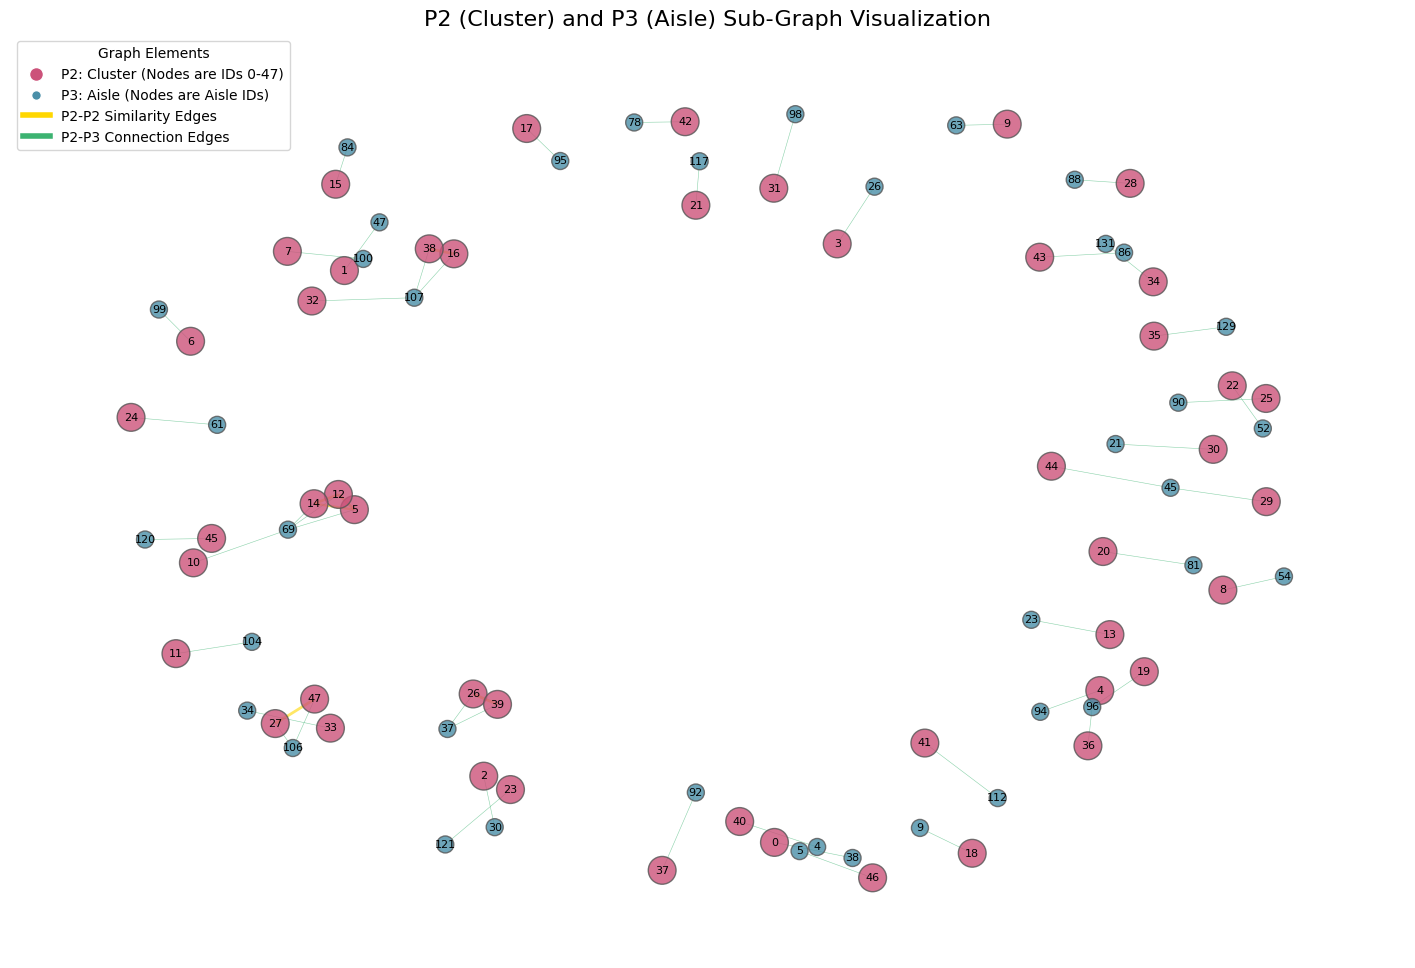

NetworkX graph successfully generated and visualized with distinct edge colors.
Total Nodes: 87
Total Edges: 54


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- 1. Define File Paths ---
P2_P2_EDGES_FILE = 'artifacts/graph/edges_p2_p2_similarity.csv'
P2_P3_EDGES_FILE = 'artifacts/graph/edges_p2_p3.csv'

# --- 2. Load Edge Data ---
try:
    # Assuming these files are in the same directory as the notebook
    df_p2p2 = pd.read_csv(P2_P2_EDGES_FILE)
    df_p2p3 = pd.read_csv(P2_P3_EDGES_FILE)
except FileNotFoundError as e:
    print(f"Error: Required file not found. Ensure '{e.filename}' is in the same directory as this notebook.")
    exit()

# --- 3. Create NetworkX Graph ---
G = nx.Graph()

# Add P2-P2 Edges (Cluster-to-Cluster Similarity)
# Ensure node names are strings for consistency (important for mixed node types)
df_p2p2['cluster_u'] = df_p2p2['cluster_u'].astype(str)
df_p2p2['cluster_v'] = df_p2p2['cluster_v'].astype(str)

p2p2_edges = [(row['cluster_u'], row['cluster_v'], {'weight': row['weight'], 'type': 'P2-P2_Similarity'}) 
              for index, row in df_p2p2.iterrows()]
G.add_edges_from(p2p2_edges)

# Add P2-P3 Edges (Cluster-to-Aisle)
# Prefix P3 nodes ('aisle_id') with 'A' to prevent ID collisions with P2 clusters.
df_p2p3['cluster_id'] = df_p2p3['cluster_id'].astype(str)
df_p2p3['aisle_id_str'] = 'A' + df_p2p3['aisle_id'].astype(str)

p2p3_edges = [(row['cluster_id'], row['aisle_id_str'], {'weight': row['weight'], 'type': 'P2-P3_Connection'}) 
              for index, row in df_p2p3.iterrows()]
G.add_edges_from(p2p3_edges)

# --- 4. Prepare Node Attributes ---
# Classify nodes into P2 (Clusters) and P3 (Aisles)
p2_nodes_list = [node for node in G.nodes() if not node.startswith('A')]
p3_nodes_list = [node for node in G.nodes() if node.startswith('A')]

# Assign color and size based on node type
node_colors = ['#CC527A' if node in p2_nodes_list else '#4A8FA8' for node in G.nodes()]
node_sizes = [400 if node in p2_nodes_list else 150 for node in G.nodes()]

# Create labels: map node ID to the display text
node_labels = {node: node.replace('A', '') for node in G.nodes()} # Remove the 'A' prefix for display

# --- 5. Prepare Edge Attributes for Visualization ---
# Define distinct colors for each edge type
p2p2_edge_color = '#FFD700'  # Gold for P2-P2 Similarity (e.g., strong connection between clusters)
p2p3_edge_color = '#3CB371'  # Medium Sea Green for P2-P3 Connection (e.g., clusters connecting to aisles)

edge_colors = []
for u, v, data in G.edges(data=True):
    if data['type'] == 'P2-P2_Similarity':
        edge_colors.append(p2p2_edge_color)
    elif data['type'] == 'P2-P3_Connection':
        edge_colors.append(p2p3_edge_color)
    else:
        edge_colors.append('#CCCCCC') # Default light gray for any other type

# Scale width by the 'weight' attribute, which is stored in the edge data
edge_widths = [data['weight'] * 2 for u, v, data in G.edges(data=True)]

# --- 6. Visualization ---

plt.figure(figsize=(18, 12))

# Calculate the layout (position of nodes)
# 'k' adjusts ideal distance between nodes. 'seed' makes the result repeatable.
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42) 

# Draw the nodes
nx.draw_networkx_nodes(G, pos, 
                       node_color=node_colors, 
                       node_size=node_sizes, 
                       alpha=0.8,
                       linewidths=1,
                       edgecolors='#555555')

# Draw the edges with new distinct colors
nx.draw_networkx_edges(G, pos, 
                       width=edge_widths, 
                       edge_color=edge_colors, # Use the list of colors we just created
                       alpha=0.6) # Increase alpha slightly for more vivid lines

# Draw the labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# --- 7. Final Touches ---
plt.title("P2 (Cluster) and P3 (Aisle) Sub-Graph Visualization", fontsize=16)

# Custom Legend for node and edge types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='P2: Cluster (Nodes are IDs 0-47)',
           markerfacecolor='#CC527A', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='P3: Aisle (Nodes are Aisle IDs)',
           markerfacecolor='#4A8FA8', markersize=7),
    Line2D([0], [0], color=p2p2_edge_color, lw=4, label='P2-P2 Similarity Edges'),
    Line2D([0], [0], color=p2p3_edge_color, lw=4, label='P2-P3 Connection Edges')
]
plt.legend(handles=legend_elements, loc='upper left', title="Graph Elements", fontsize=10)

plt.axis('off') # Hide the axis ticks and frame
plt.show()

print("NetworkX graph successfully generated and visualized with distinct edge colors.")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")